In [1]:
import qctoolkit as qtk
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import re
from datetime import datetime
import qmnet_model as qnm
import qmnet_tools as qnt
import qmnet_train as qntrain
import tensorflow as tf
from IPython.core.debugger import Tracer

%matplotlib inline

clear_output()

In [2]:
from horton import GOBasisFamily
#basis = GOBasisFamily('basis', filename='basis/sto2g/H_Ne_uncontracted.nwchem')
#basis = '3-21g'
#basis = 'sto-3g'
#basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Ne.nwchem')
basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Be-s.nwchem')

resolution = 0.005
batch_size = 30000

In [5]:
molstr_list = [
    'HH',
#     'HHe+',
#     'HLi',
#     'HBe+',
#     'HeHe',
#     'HeLi+',
#     'HeBe',
#     'LiLi',
#     'LiBe+',
#     'BeBe',
]

In [6]:
inp_grp = []
#inp_dump = []
for molstr in molstr_list:
    if '+' in molstr:
        charge = 1
    elif '-' in molstr:
        charge = -1
    else:
        charge = 0
    alist = re.findall('[A-Z][a-z]*', molstr)
    Zs = [qtk.n2Z(a) for a in alist]
    inp_list = []
    inp_grp.append(inp_list)
    #inp_dump.append(inp_list)
    res = resolution
    for R in np.arange(0.3, 4.0 + res, res):
        mol = qtk.Molecule()
        ZR = [[Zs[0], 0,0,0], [Zs[1], R, 0, 0]]
        mol.build(ZR)
        mol.charge = charge
        mol.name = mol.name + '_%s' % str(R)
        inp = qtk.QMInp(mol, program='horton', basis_set=basis, scf_step=30)
        try:
            inp.run()
            D, U = np.linalg.eigh(inp.olp)
            inp.X = U / np.sqrt(D)
            
            # to save inps into pickle file
            #inp.delete_ht_types()
            #inp.delete_matrices()
            
            inp_list.append(inp)
        except:
            pass
    print "%s finished" % mol.name
print [len(inp) for inp in inp_grp]

H2_4.0 finished
[741]


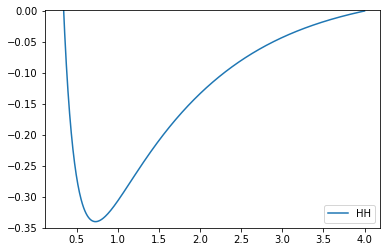

In [7]:
for i in range(len(inp_grp)):
    inp = inp_grp[i]
    E = np.array([o.Et for o in inp])
    E = E-E[-1]
    R = [o.molecule.R[1,0] for o in inp]
    #print E
    plt.plot(R, E, label=molstr_list[i])
plt.ylim(-0.35, 0.001)
plt.legend()

In [11]:
inp_grp[0][0].olp.shape

(4, 4)

In [8]:
inp = inp_grp[0][5]
I_np, Er_np, occ, nn = qnt.get_input_tensor(inp)
C = inp.ht_exp_alpha.coeffs.__array__()
print qnt.get_output(I_np, Er_np, occ, nn, C)
print inp.Et

-0.730430578246
-0.730430578246


In [9]:
reload(qnt)
inp_train, inp_test, inp_valid = qnt.train_test_valid(inp_grp, 0, [0])
# print len(inp_train), len(inp_test), len(inp_valid)
I_train, Er_train, occ_train, nn_train, C_train, y_train = qnt.tfIO_batch(inp_train, batch_size)
I_test, Er_test, occ_test, nn_test, C_test, y_test = qnt.tfIO_batch(inp_test, batch_size)
I_valid, Er_valid, occ_valid, nn_valid, C_valid, y_valid = qnt.tfIO_batch(inp_valid, batch_size)

I_valid2, Er_valid2, occ_valid2, nn_valid2, C_valid2, y_valid2 = qnt.tfIO(inp_valid, [1,3,5])
print I_valid2.shape
print I_test[0].shape
print I_train[0].shape
print qnt.validation_inds(inp_valid)

(3, 7, 4, 4)
(75, 7, 4, 4)
(666, 7, 4, 4)
(43, 86, 413, 740)


In [69]:
lr = 0.001
const_lr = {
    'learn_rate_start':0.1, 
    'learn_rate_min':lr, 
    'learn_rate_base':1.0, 
}
vary_lr_H2 = {
    'learn_rate_start':0.001, 
    'learn_rate_min':0.000001, 
    'learn_rate_steps':100, 
    'learn_rate_base':0.8
}

vary_lr = {
    'learn_rate_start':0.001, 
    'learn_rate_min':0.00005, 
    'learn_rate_steps':500, 
    'learn_rate_base':0.8
}

reload(qnt)
reload(qnm)
reload(qnm.qnl)
reload(qntrain)
train = qntrain.train
#qm_model = qnm.I0_S2x5_O1x3
#qm_model = qnm.Ix0_dS5x5_O3x5
qm_model = qnm.I0_S1x2_d_S1x2_O1x3
#qm_model = qnm.I3_S3O3x5d_S3O3x5_O3x3
#qm_model = qnm.I3_S5x10_d_S5x5_dS2_O3x5
#qm_model = qnm.Ix3_R5_O2
#qm_model = qnm.Ix3_R5h2b_O2
#qm_model = qnm.Ix3_R3h2b_R5h1b_O2
#qm_model = qnm.I2_R5h2b_d_R3h1b_d_R2h1b_O5
#qm_model = qnm.Fock_error_test
#qm_model = qnm.Ix0_dS5x5_O3x5
#qm_model = qnm.I2_R5h2b_R3h1b_O2

In [70]:
tf.reset_default_graph()

train(qm_model, inp_grp, 'H2_simple_test1', valid_ind=0, train_list=[0], threshold=1E-5,
      from_scratch=False, batch_size=16, print_step=50, kp=1.0, save_step=200,
      #loss='fock_occ', 
      **vary_lr_H2)
#train('increment_test', valid_ind=2, train_list=[0, 1, 3], 
#      from_scratch=False, batch_size=256, print_step=200, **vary_lr)
# train(qm_model, inp_grp, 'A2_rnn_test', valid_ind=2, from_scratch=False, batch_size=256, 
#       print_step=200, threshold=1E-4, **vary_lr)

root name: H2_simple_test1
model: <function I0_S1x2_d_S1x2_O1x3 at 0x7f62e9d9d488>
train/test/validation size: 666/75/741 
optimizer: <class 'tensorflow.python.training.adam.AdamOptimizer'>
reg_scale: 0.0
keep_prob: 1.0
batch size: 16
number of batches: 42
learning rate min: 1e-06
learning rate steps: 100
learning rate start: 0.001
learning rate base: 0.8
print step: 50
history step: 1
threshold: 1e-05
maxiter: 100000
execuate time: 2017/10/10 15:32:34


INFO:tensorflow:Restoring parameters from H2_simple_test1.ckpt
no model found, or reload failed, start from scratch

epoch:    50 train/test/validatoin error: 0.004357/0.004947/0.004413 at rate 0.000896
epoch:   100 train/test/validatoin error: 0.001922/0.001843/0.001777 at rate 0.000802
epoch:   150 train/test/validatoin error: 0.002676/0.004544/0.004090 at rate 0.000717
epoch:   200 train/test/validatoin error: 0.005398/0.003405/0.004596 at rate 0.000641
epoch:   200 train/test/validatoin error: 0.005398/0.003405/0.004596 at rate 0.0

In [28]:
#qtk.save([train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist, learn_rate_hist], "%s_hist.pkl" % root_name)

data = qtk.load('H2_deep_test_hist.pkl')
err_train, err_test, err_valid, C_valid_hist, C_test_hist, learn_rate_hist = data

In [97]:
def get_C_prd(model_file_name, inp_valid):
    I_v, Er_v, occ_v, nn_v, C_v, y_v = tfIO_batch(inp_valid, 8000)
    
    tf.reset_default_graph()
    g = tf.Graph()

    with g.as_default():
        y_prd, C_prd, param = qmnet_model(g)
        I, Er, occ, nn, keep_prob = param
        saver = tf.train.Saver()
        with tf.Session() as sess:
            saver.restore(sess, model_file_name)
            valid_dict = {I:I_v[0], Er:Er_v[0], occ:occ_v[0], nn:nn_v[0], keep_prob:1.0}
            return sess.run([C_prd, y_prd], feed_dict=valid_dict)

INFO:tensorflow:Restoring parameters from A2_deep_test.ckpt


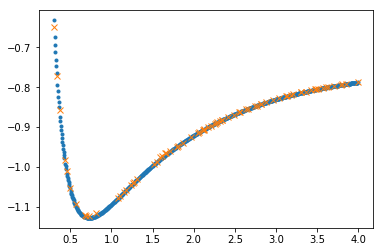

In [99]:
C_prd, E_prd = get_C_prd('H2_deep_test.ckpt', inp_test)
E_tar = np.array([inp.Et for inp in inp_train])
R_tar = np.array([inp.molecule.R[1,0] for inp in inp_train])
R_prd = np.array([inp.molecule.R[1,0] for inp in inp_test])

plt.plot(R_tar, E_tar, ls='', marker='.')
plt.plot(R_prd, E_prd, ls='', marker='x')

In [55]:
# def train(root_name='model', learn_rate=0.001, valid_ind=2, 
#           train_list=range(len(inp_grp)), print_step=5, from_scratch=False,
#           threshold=1E-5, maxiter=100000
#          ):

total_list = range(10)
tags = [str(i) for i in range(1, 10)]
inds = [total_list[:i] for i in range(1, 10)]

del tags[2]
del inds[2]

for i in range(len(tags)):
    tag = tags[i]
    ind = inds[i]
    train('increment_full_2-%s' % tag, 0.02, 2, ind, 10)